In [ ]:
# GPU check
!nvidia-smi

# Install PyTorch
!pip install --quiet torch torchvision torchaudio


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12})

# Config
CSV_PATH = "LA_Volume_Cleaned.csv"   # Path to your cleaned file
LOOKBACK = 24      # hours of history
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
HIDDEN_CHANNELS = 64
DROPOUT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_SIZE = 0.2
VAL_SIZE = 0.1


In [ ]:
from google.colab import files

# Upload cleaned dataset from your computer
uploaded = files.upload()


Saving LA_Volume_Cleaned (1).csv to LA_Volume_Cleaned (1).csv


In [ ]:
import pandas as pd

# Load your cleaned CSV file (after uploading it to Colab)
df = pd.read_csv("LA_Volume_Cleaned (1).csv", index_col=0, parse_dates=True)

# Ensure rows are in chronological order
df.sort_index(inplace=True)

# Display basic info
print("✅ Dataset loaded successfully!")
print(df.info())
print("\nDate range:", df.index.min(), "to", df.index.max())
print("Shape:", df.shape)

# Preview first few rows
df.head()


✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2023-04-01 00:00:00 to 2023-09-30 23:00:00
Columns: 229 entries, 0 to 228
dtypes: float64(229)
memory usage: 7.7 MB
None

Date range: 2023-04-01 00:00:00 to 2023-09-30 23:00:00
Shape: (4392, 229)


,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
Time,,,,,,,,,,,,,,,,,,,,,
2023-04-01 00:00:00,6.60,3.85,12.65,25.30,6.05,6.05,13.2,6.60,0.0,6.05,...,18.70,11.55,12.10,1.1,2.161360,0.000000,4.950,0.0,3.3,3.386842
2023-04-01 01:00:00,6.05,3.85,13.20,16.50,8.80,9.35,13.2,6.60,0.0,0.55,...,15.95,7.15,8.25,1.1,2.160538,0.000000,6.600,0.0,6.6,3.502632
2023-04-01 02:00:00,7.15,3.85,13.20,18.15,12.65,19.25,13.2,6.60,0.0,0.00,...,22.00,6.05,1.10,1.1,2.159716,6.050000,6.600,0.0,6.6,3.618421
2023-04-01 03:00:00,6.60,3.85,7.15,7.70,2.75,20.35,12.1,6.60,0.0,0.00,...,17.05,7.15,0.00,1.1,2.158894,2.750000,4.400,0.0,6.6,3.734211
2023-04-01 04:00:00,6.05,3.85,18.15,17.05,0.00,19.25,14.3,8.25,0.0,0.00,...,18.70,4.40,0.00,1.1,2.158072,2.855479,4.422,0.0,6.6,3.850000


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Collapse across sites to get total hourly volume
y_all = df.sum(axis=1)

# Scale features (optional, but helps neural networks)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y_all.values.reshape(-1, 1))

# Create sequences for temporal modeling
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 24  # use past 24 hours to predict the next hour
X, y = create_sequences(y_scaled, seq_length=SEQ_LEN)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ Data ready for CNN")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


✅ Data ready for CNN
X_train shape: (3494, 24, 1)
y_train shape: (3494, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten

# Define TCN-like CNN
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,041 (433.75 KB)

 Trainable params: 111,041 (433.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2738 - val_loss: 0.0767
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0669 - val_loss: 0.0704
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0517 - val_loss: 0.0704
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0467 - val_loss: 0.0690
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0420 - val_loss: 0.0699
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0430 - val_loss: 0.0713
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0377 - val_loss: 0.0753
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0359 - val_loss: 0.0781
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0398 - val_loss: 0.0735
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0327 - val_loss: 0.0740
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0305 - val_loss: 0.0770
Epoch 12/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14m

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


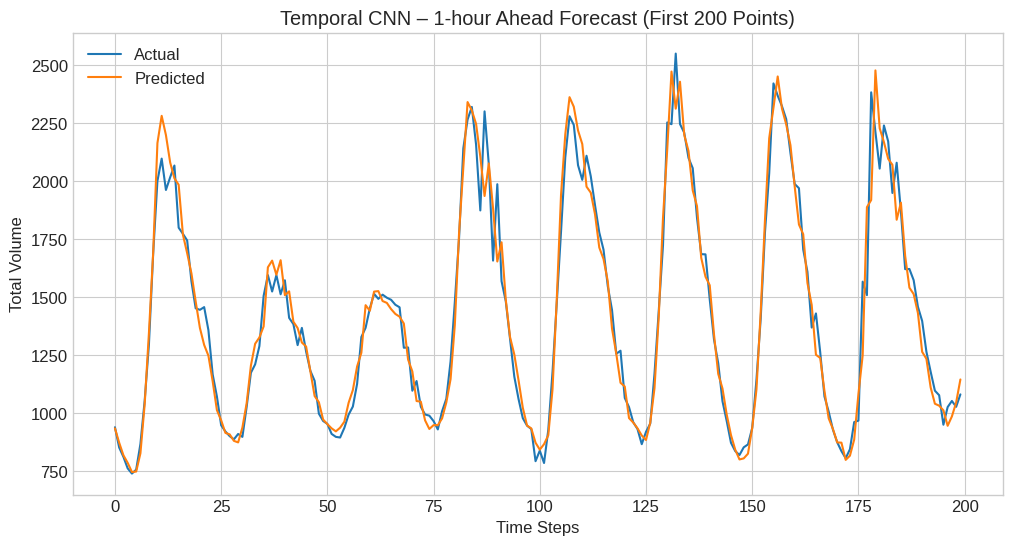

In [ ]:
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Inverse scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label="Actual")
plt.plot(y_pred_inv[:200], label="Predicted")
plt.title("Temporal CNN – 1-hour Ahead Forecast (First 200 Points)")
plt.xlabel("Time Steps")
plt.ylabel("Total Volume")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale all site columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.values)

# Function to create sequences (past n hours → next hour)
def create_multivariate_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # past seq_length hours
        y.append(data[i+seq_length, :])    # next-hour target for all sites
    return np.array(X), np.array(y)

SEQ_LEN = 24  # use past 24 hours to predict next hour
X, y = create_multivariate_sequences(data_scaled, SEQ_LEN)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ Data ready for multivariate CNN")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


✅ Data ready for multivariate CNN
X_train shape: (3494, 24, 229)
y_train shape: (3494, 229)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten

# Temporal CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal', input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y.shape[1])  # predict all sites at once
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 24, 128)        │        88,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 229)            │        29,541 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,229 (2.14 MB)

 Trainable params: 560,229 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.9896 - val_loss: 0.5760
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.6998 - val_loss: 0.5407
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.6317 - val_loss: 0.5349
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5822 - val_loss: 0.5305
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.5489 - val_loss: 0.5284
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5181 - val_loss: 0.5278
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.4954 - val_loss: 0.5171
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.4706 - val_loss: 0.5276
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.4552 - val_loss: 0.5195
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.4344 - val_loss: 0.5190
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4237 - val_loss: 0.5354
Epoch 12/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


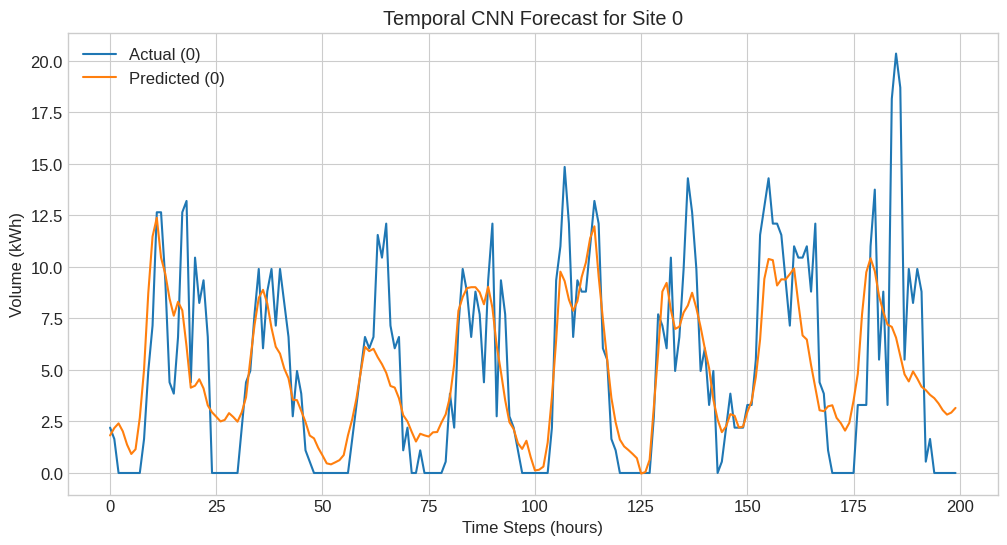

In [ ]:
# Predict next-hour volumes
y_pred = model.predict(X_test)

# Inverse scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Pick one site (for visualization)
site_idx = 0  # you can change to another site index
site_name = df.columns[site_idx]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200, site_idx], label=f"Actual ({site_name})")
plt.plot(y_pred_inv[:200, site_idx], label=f"Predicted ({site_name})")
plt.title(f"Temporal CNN Forecast for Site {site_name}")
plt.xlabel("Time Steps (hours)")
plt.ylabel("Volume (kWh)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE per site
rmse_per_site = []
for i in range(y_test_inv.shape[1]):  # loop through all sites
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    rmse_per_site.append(rmse)

# Convert to pandas Series for readability
import pandas as pd
rmse_df = pd.Series(rmse_per_site, index=df.columns, name="RMSE")

# Overall average RMSE
overall_rmse = np.mean(rmse_per_site)

print(" RMSE per site (first 10):")
print(rmse_df.head(10))
print(f"\n Overall average RMSE across all sites: {overall_rmse:.3f}")


 RMSE per site (first 10):
0    4.140656
1    0.004223
2    4.711485
3    5.525584
4    2.045064
5    4.339364
6    2.729778
7    2.068150
8    2.695000
9    2.172706
Name: RMSE, dtype: float64

 Overall average RMSE across all sites: 3.513


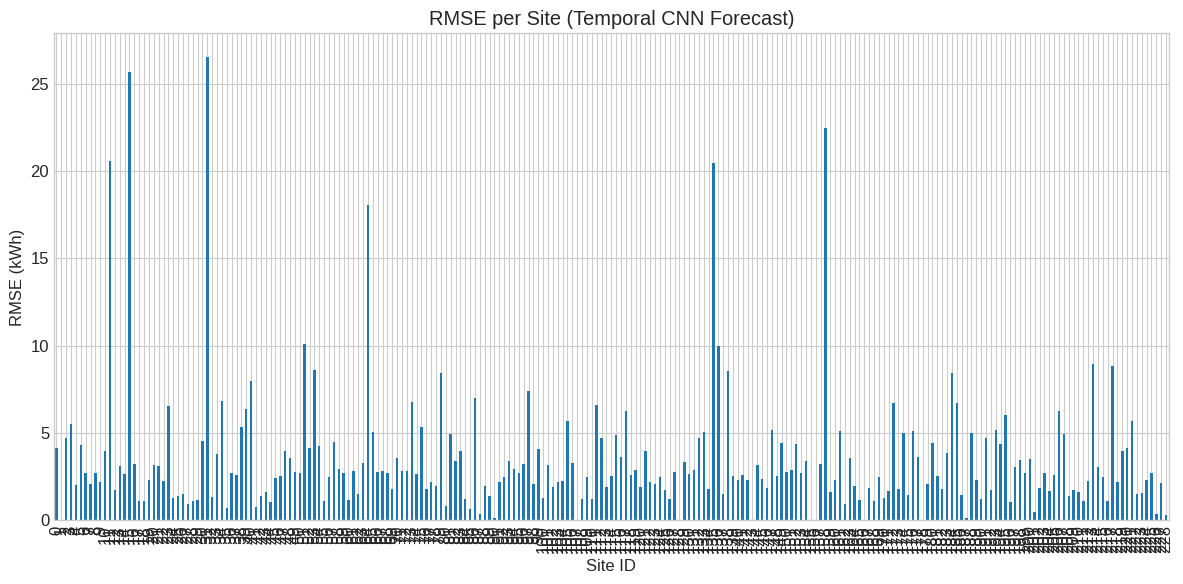

In [ ]:
plt.figure(figsize=(12, 6))
rmse_df.plot(kind='bar')
plt.title("RMSE per Site (Temporal CNN Forecast)")
plt.ylabel("RMSE (kWh)")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("LA_Volume_Cleaned (1).csv", index_col=0, parse_dates=True)
df.sort_index(inplace=True)

# Sum across all sites → total hourly volume
total_volume = df.sum(axis=1).values.reshape(-1, 1)

# Scale data
scaler = StandardScaler()
total_scaled = scaler.fit_transform(total_volume)

# Create sequences: past 24 hours → next hour
SEQ_LEN = 24
X, y = [], []
for i in range(len(total_scaled) - SEQ_LEN):
    X.append(total_scaled[i:i+SEQ_LEN])
    y.append(total_scaled[i+SEQ_LEN])
X, y = np.array(X), np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ Data ready for total-volume CNN")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


✅ Data ready for total-volume CNN
X_train shape: (3494, 24, 1)
y_train shape: (3494, 1)


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,041 (433.75 KB)

 Trainable params: 111,041 (433.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2879 - val_loss: 0.0710
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0699 - val_loss: 0.0713
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0525 - val_loss: 0.0739
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0486 - val_loss: 0.0827
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0436 - val_loss: 0.0758
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0381 - val_loss: 0.0731
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0388 - val_loss: 0.0791
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0347 - val_loss: 0.0735
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0317 - val_loss: 0.0837
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0363 - val_loss: 0.0794
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0330 - val_loss: 0.0796
Epoch 12/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Total-volume RMSE: 137.176


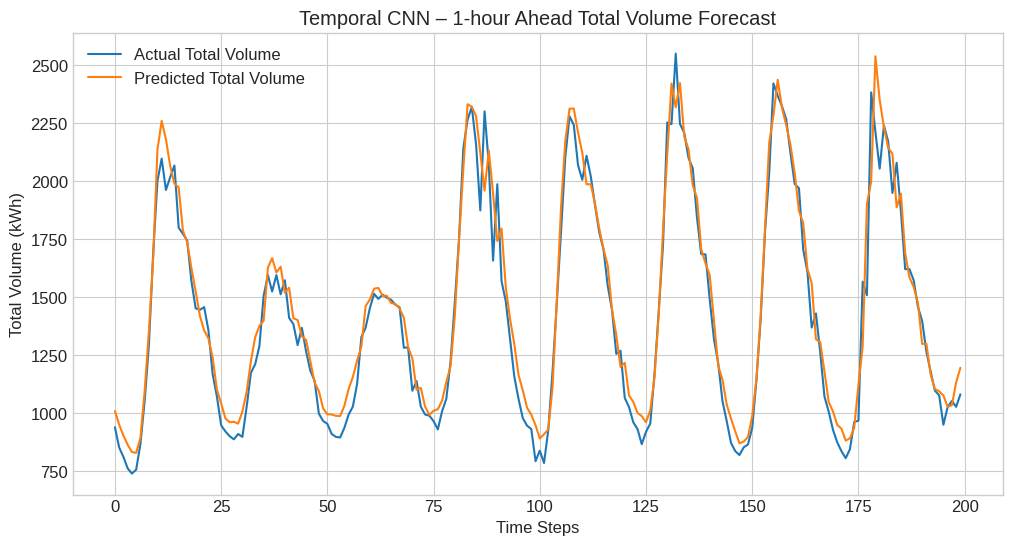

In [ ]:
# Predict next-hour total volumes
y_pred = model.predict(X_test)

# Inverse scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Compute RMSE
total_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Total-volume RMSE: {total_rmse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label="Actual Total Volume")
plt.plot(y_pred_inv[:200], label="Predicted Total Volume")
plt.title("Temporal CNN – 1-hour Ahead Total Volume Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Total Volume (kWh)")
plt.legend()
plt.show()
